<a href="https://colab.research.google.com/github/CoryLaidlaw/fastai_tutorial_notes/blob/main/Collaborative_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from fastai.tabular.all import *
from fastai.collab import *

# Get Data

Using Movielens 100k data dataset

In [2]:
path = untar_data(URLs.ML_100k)

Main data is in u.data. Specify tab delimiter, and columns to keep the names from

In [3]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


Load cooresponding movie titles from u.item

In [4]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [5]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)
2,226,242,5,Kolya (1996)
3,154,242,3,Kolya (1996)
4,306,242,5,Kolya (1996)


# DataLoader

Building DataLoaders object, default takes first column for user, second column for the item, and third colum for ratings. Change item_name to use titles instead of ids

In [6]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In [7]:
dls.show_batch()

,user,title,rating
0,669,Willy Wonka and the Chocolate Factory (1971),5
1,571,Die Hard (1988),2
2,92,Mary Shelley's Frankenstein (1994),3
3,109,From Dusk Till Dawn (1996),4
4,642,"Saint, The (1997)",5
5,160,Star Trek IV: The Voyage Home (1986),2
6,387,Kalifornia (1993),4
7,194,"Hunt for Red October, The (1990)",4
8,833,Twelve Monkeys (1995),3
9,555,Notorious (1946),5


# Learner

Use collab_trainer to make and train a collaborative filtering model. It uses a simple dot product model with 50 latent factors.

In [8]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [9]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.950053,0.931828,00:11
1,0.858038,0.859576,00:11
2,0.719477,0.820362,00:11
3,0.588113,0.808803,00:12
4,0.493888,0.809537,00:11


# Interpertaion

Analyzing results of model, keeping the 1000 most rated movies.

In [10]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

The model has learned one bias per movie, a unique number independent of users that can be interperted as the intrinsic 'value' of the movie. Grabbing the bias of movies in top_movies

In [11]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

Comparing bias to average ratings

In [12]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

Looking at movies with the worst bias

In [13]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3349),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2954), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2913), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2740), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2720),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2427), 'Thinner (1996)', 2.4489795918367347),
 (tensor(-0.2347), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2314), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2302), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2197), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.2168), 'Booty Call (1997)', 2.1666666666666665),
 (tensor(-0.2160), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2115), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2104), 'Sgt. Bilko (1996)', 2.5675675675675675),
 (tensor(-0.20

Looking at movies with the best bias

In [14]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.5943), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5683), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5608), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5431), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5324), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5260), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.5077), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.4843), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4778), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.4761), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.4685), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4671), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4659), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4625), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4508), 'Boot, Das (1981)', 4.203980099502488)]

# Weights

Analyzing the latent factor that the model has learned by grabbintg weights for each top_movie

In [15]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

Using PCA to reduce dimensions

In [16]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [17]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

Highest scores on the first dimension

In [18]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1281), 'Wrong Trousers, The (1993)'),
 (tensor(1.1118), 'Shall We Dance? (1996)'),
 (tensor(1.1004), 'Casablanca (1942)'),
 (tensor(1.0932),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(1.0913), 'Lawrence of Arabia (1962)'),
 (tensor(1.0352), 'Chinatown (1974)'),
 (tensor(1.0300), 'Secrets & Lies (1996)'),
 (tensor(1.0155), 'Close Shave, A (1995)'),
 (tensor(1.0067), 'Some Folks Call It a Sling Blade (1993)'),
 (tensor(1.0001), 'Godfather, The (1972)')]

Lowest scores

In [19]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2041), 'Home Alone 3 (1997)'),
 (tensor(-1.1757), 'Jungle2Jungle (1997)'),
 (tensor(-1.1311), 'Super Mario Bros. (1993)'),
 (tensor(-1.1073), 'Leave It to Beaver (1997)'),
 (tensor(-1.1020), 'Congo (1995)'),
 (tensor(-1.0817), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.0727), 'Bio-Dome (1996)'),
 (tensor(-1.0722), 'Striptease (1996)'),
 (tensor(-1.0713), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.0641), 'Lawnmower Man 2: Beyond Cyberspace (1996)')]

Second dimension highest and lowest

In [20]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [21]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1581), 'Raiders of the Lost Ark (1981)'),
 (tensor(1.1365), 'Braveheart (1995)'),
 (tensor(1.0845), 'Titanic (1997)'),
 (tensor(0.9555), 'Forrest Gump (1994)'),
 (tensor(0.8670), 'Top Gun (1986)'),
 (tensor(0.8489), "It's a Wonderful Life (1946)"),
 (tensor(0.8101), 'Return of the Jedi (1983)'),
 (tensor(0.8097), 'True Lies (1994)'),
 (tensor(0.8081), 'Fugitive, The (1993)'),
 (tensor(0.8025), 'Back to the Future (1985)')]

In [22]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.8842), 'Clockwork Orange, A (1971)'),
 (tensor(-0.8208), 'Brazil (1985)'),
 (tensor(-0.8002), 'Big Night (1996)'),
 (tensor(-0.7740), 'Spice World (1997)'),
 (tensor(-0.7646), 'Lost Highway (1997)'),
 (tensor(-0.7576), 'Three Colors: Blue (1993)'),
 (tensor(-0.7552), 'Angels and Insects (1995)'),
 (tensor(-0.7539), 'Trainspotting (1996)'),
 (tensor(-0.7481), 'Jude (1996)'),
 (tensor(-0.7481), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)')]

Plotting movies according to their scores

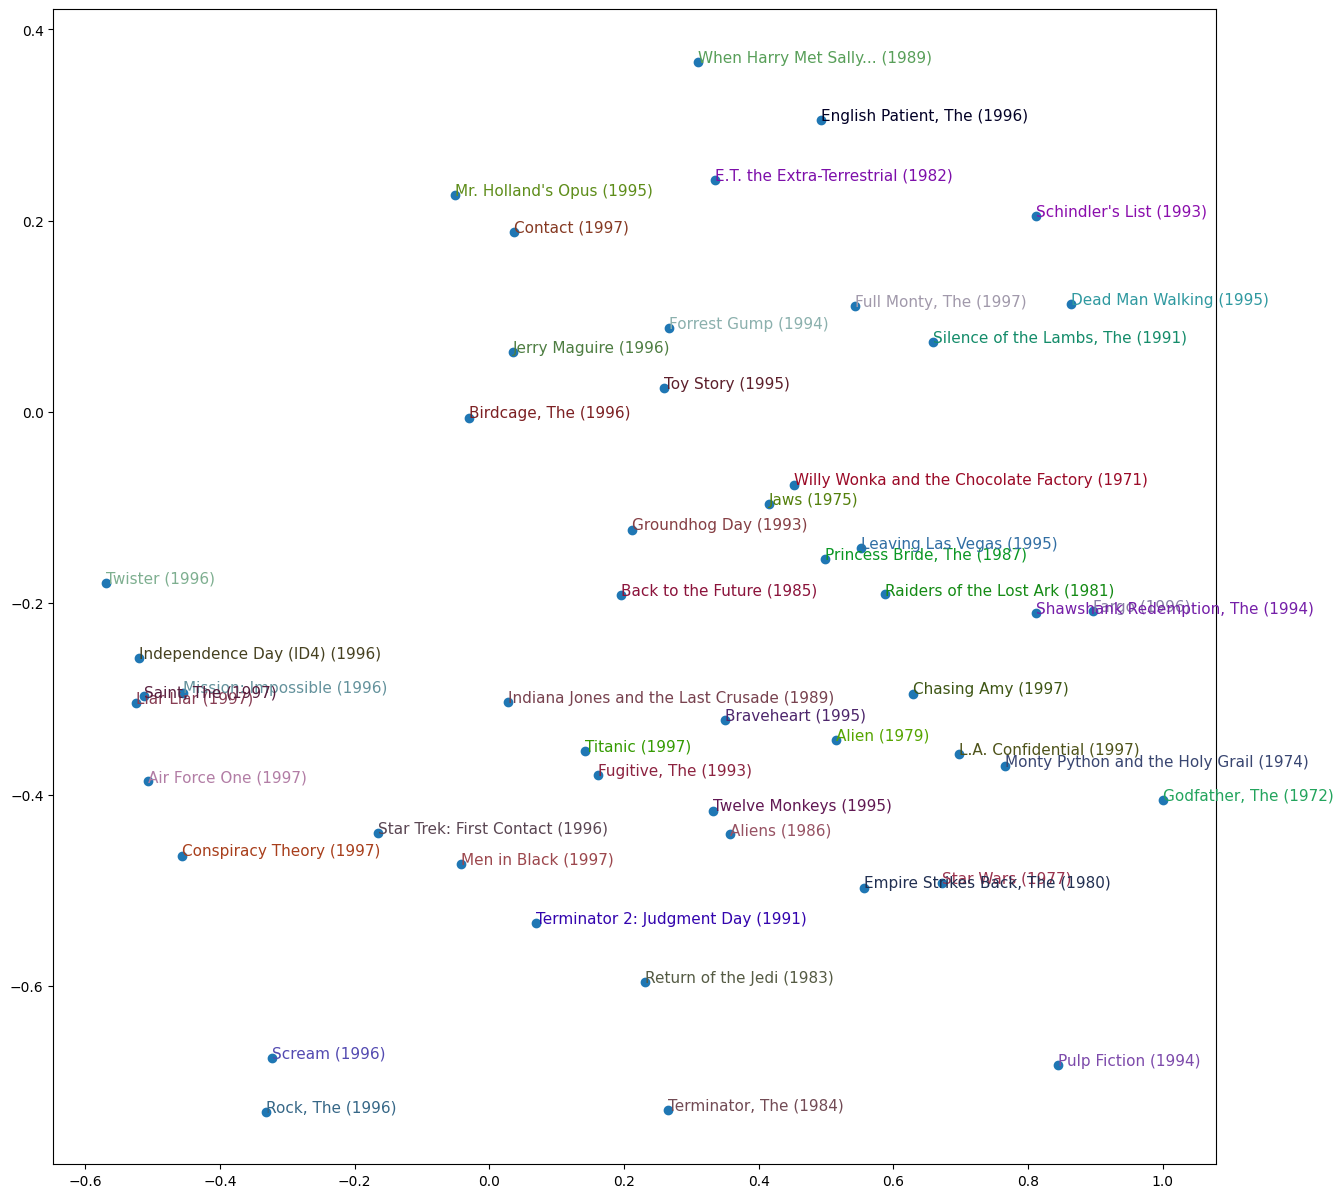

In [23]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()